# Construct Training/Test Sequences

In [7]:
import os, sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  # add project root

import torch

from src.data_loader import prepare_movielens_sequences
from src.datasets import SequenceDataset, collate_fn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Call the function to load and preprocess the MovieLens data
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data/raw'))
bundle = prepare_movielens_sequences(
    ratings_path=os.path.join(data_dir, 'ml_32m_ratings.csv'),
    max_len=50,
    min_user_interactions=5,
)

train_sequences = bundle["train_sequences"]
test_sequences = bundle["test_sequences"]
num_items = bundle["num_items"]
mask_id = bundle["mask_id"]
pad_id = bundle["pad_id"]

# Preview the processed data
print(train_sequences[:10])
print(test_sequences[:10])
print(bundle["stats"])

# Build loaders
from torch.utils.data import DataLoader
train_ds = SequenceDataset(train_sequences, max_len=50)
test_ds  = SequenceDataset(test_sequences,  max_len=50)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False, collate_fn=collate_fn)


[[303, 586, 785, 818, 1174, 1195, 80, 601, 1145, 1244, 2178, 36, 110, 1231, 1654, 1937, 17, 30, 1093, 1123, 1183, 1191, 1215, 1656, 1873, 2222, 25, 888, 903, 1155, 1263, 2430, 1019, 1323, 1369, 1631, 304, 1033, 1198, 2223, 299, 636, 951, 1728, 1864, 2239, 2621, 906, 1357, 1932], [293, 376, 152, 340, 345, 581, 229, 315, 588, 335, 184, 251, 453, 34, 223, 39, 360, 450, 352, 234, 280, 185, 373, 346, 496, 353, 535, 580, 48, 579, 590, 31, 192, 274, 546, 235, 578, 504, 217, 377, 220, 547, 206, 215, 302, 462, 587, 516, 609, 358], [3526, 3641, 3600, 3726, 3598, 3155, 3344, 3118, 3354, 2942, 2857, 2941, 2856, 2610, 2515, 2656, 2526, 2550, 2551, 2552, 2553, 7020, 3654, 4960, 5763, 3481, 3878, 3917, 4776, 6444, 3694, 5243, 4792, 5706, 6223, 3914, 6249, 6418, 5193, 4891, 4597, 11, 2263, 62, 1785, 5274, 26, 2061, 530, 1869], [1180, 1747, 2654, 1240, 1294, 2026, 2592, 2608, 2735, 2619, 2679, 221, 2631, 2790, 3111, 2338, 2515, 2597, 3083, 2622, 2961, 2400, 2632, 1463, 2750, 2672], [585, 149, 583, 293,

# Evaluate Trained BERT4Rec Model

In [10]:
from src.model import BERT4Rec
from src.eval import evaluate_model_topk

CKPT_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'model/bert4rec_checkpoint.pth'))
checkpoint = torch.load(CKPT_PATH)
model = BERT4Rec(num_items=num_items, max_len=50, embed_dim=128, num_heads=4, num_layers=2, dropout=0.1)
model.load_state_dict(checkpoint["model_state_dict"])

# --- evaluate ---
model.eval()
metrics_bert = evaluate_model_topk(
    model=model,
    loader=test_loader,
    device=device,
    mask_token_id=mask_id,
    pad_id=pad_id,
    items_only_head=False
)
metrics_bert

{'Hit@5': 0.045588908573362265,
 'Precision@5': 0.009117781714673843,
 'NDCG@5': 0.02834071043960347,
 'MRR@5': 0.02273258089986746,
 'Hit@10': 0.08096124370483906,
 'Precision@10': 0.008096124370481994,
 'NDCG@10': 0.03965704682454884,
 'MRR@10': 0.02733171355078541,
 'Hit@20': 0.1389463940920039,
 'Precision@20': 0.006947319704596602,
 'NDCG@20': 0.05419287349083791,
 'MRR@20': 0.03125594970475865}

# Evaluate Baseline Method

In [9]:
"""Evaluate Baseline model (popularity based recommendation)"""

from collections import Counter
from src.eval import evaluate_baseline_topk

pop = Counter()
for seq in train_sequences:
    pop.update(seq)

popular_items = [iid for iid, _ in pop.most_common()]

Kmax = 20
popular_topK = popular_items[:Kmax]

def num_examples(dataloader):
    return sum(batch.size(0) if hasattr(batch, "size") else len(batch) for batch in dataloader)

N = num_examples(test_loader)

import itertools
items_pred_pop = list(itertools.repeat(popular_topK, N))

metrics_baseline = evaluate_baseline_topk(
    items_pred=items_pred_pop, 
    loader=test_loader,
    device=device,
    mask_token_id=mask_id,
    pad_id=pad_id
)
metrics_baseline

{'Hit@5': 0.014615721480183929,
 'Precision@5': 0.0029231442960367684,
 'NDCG@5': 0.008772530379422374,
 'MRR@5': 0.006876820537319814,
 'Hit@10': 0.02660389752572805,
 'Precision@10': 0.0026603897525730685,
 'NDCG@10': 0.01259598234592363,
 'MRR@10': 0.008422539464525357,
 'Hit@20': 0.046713577641977026,
 'Precision@20': 0.002335678882099212,
 'NDCG@20': 0.01766486369957713,
 'MRR@20': 0.009805033366792311}

# Visualize Evaluation Results

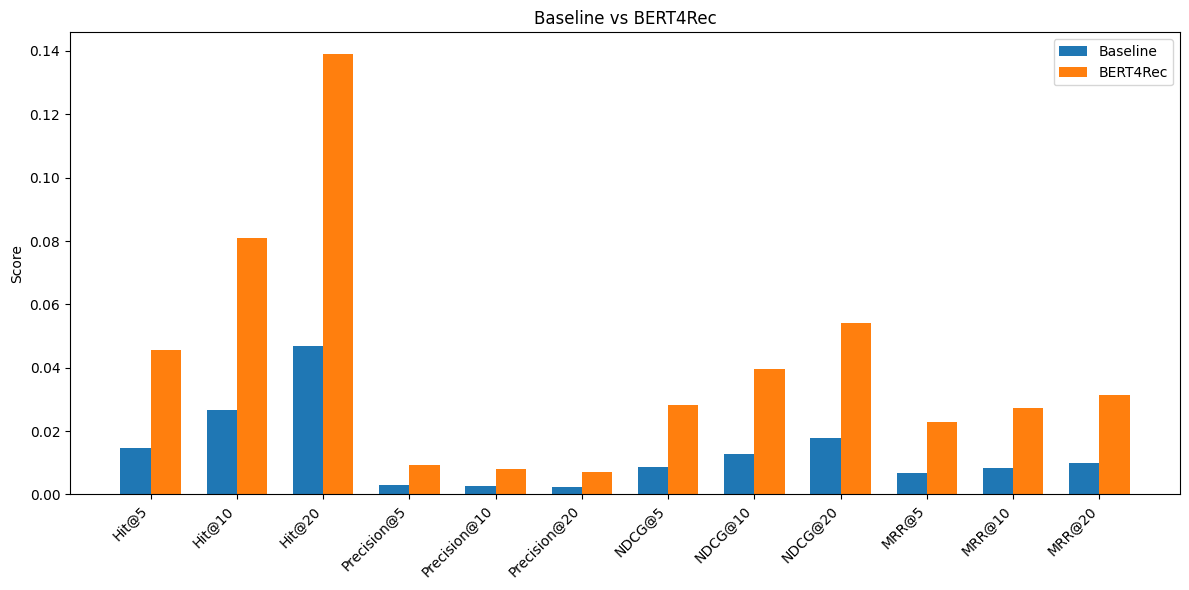

In [11]:
import matplotlib.pyplot as plt

K_LIST = [5,10,20]

metrics = [f"Hit@{K}" for K in K_LIST] + [f"Precision@{K}" for K in K_LIST] + [f"NDCG@{K}" for K in K_LIST] +  [f"MRR@{K}" for K in K_LIST]
x = range(len(metrics))
width = 0.35

plt.figure(figsize=(12,6))
plt.bar([i - width/2 for i in x],
        [metrics_baseline[m] for m in metrics],
        width=width, label="Baseline")
plt.bar([i + width/2 for i in x],
        [metrics_bert[m] for m in metrics],
        width=width, label="BERT4Rec")

plt.xticks(x, metrics, rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Baseline vs BERT4Rec")
plt.legend()
plt.tight_layout()
plt.show()